In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

In [25]:
# 1. Model Parameters (from problem_set.pdf)
# =============================================================================
# Economic parameters
GAMMA = 2.0  # Coefficient of relative risk aversion
BETA_ANNUAL = 0.985  # Annual discount factor
YEARS_PER_PERIOD = 20  # Number of years in one period
BETA = BETA_ANNUAL ** YEARS_PER_PERIOD  # Discount factor for a 20-year period
R_ANNUAL = 0.025  # Annual real interest rate
R = (1 + R_ANNUAL) ** YEARS_PER_PERIOD - 1  # Interest rate for a 20-year period

# Productivity states (low, medium, high)
Y_LEVELS = np.array([0.8027, 1.0, 1.2457])
N_Y = len(Y_LEVELS)  # Number of productivity states

# Transition probability matrix for productivity
P = np.array([
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281, 0.1360],
    [0.0021, 0.2528, 0.7451]
])

# Population shares for each productivity type at young age
POP_SHARES = np.array([1/3, 1/3, 1/3])


In [67]:
# Discretized grid for assets. These are assumed values.
# The problem states borrowing is not allowed, so the grid starts at 0.
A_MAX = 2.0  # Assumed maximum value for assets
A_SIZE = 500  # Assumed number of points in the asset grid
A_GRID = np.linspace(0.0, A_MAX, A_SIZE)

In [68]:
# =============================================================================
# 2. Utility Function (Corrected for Vectorized Operations)
# =============================================================================
def utility(c, gamma=GAMMA):
    """
    Calculates the CRRA utility for a given consumption level c.
    This version is vectorized to handle NumPy array inputs correctly.
    """
    # Ensure c is a NumPy array for consistent processing
    c = np.asarray(c)

    # Create an output array of the same shape, initialized to handle -inf
    u = np.full(c.shape, -np.inf, dtype=np.float64)

    # Create a boolean mask for positive consumption values
    positive_c_mask = c > 1e-10

    # Calculate utility only for the elements where consumption is positive
    if gamma == 1.0:
        u[positive_c_mask] = np.log(c[positive_c_mask])
    else:
        u[positive_c_mask] = (c[positive_c_mask]**(1 - gamma)) / (1 - gamma)

    # If the original input was a single number, return a single number
    if c.ndim == 0:
        return u.item()

    return u

In [69]:
# 3. Core Solver using Optimization Routine (minimize_scalar)
# =============================================================================
def solve_model_with_optimizer(pension_b, tax_tau):
    """
    Solves the 3-period lifecycle model using backward induction.
    This version uses scipy.optimize.minimize_scalar for the optimization step.
    """
    # --- Period 3: Old Age ---
    # In the last period, individuals consume all remaining wealth. [cite: 3]
    # Wealth = (1+R)*a3 + pension_b
    # Value function V3(a3) = u((1+R)*a3 + b)
    v3 = utility((1 + R) * A_GRID + pension_b, GAMMA)

    # --- Period 2: Middle Age ---
    v2 = np.zeros((A_SIZE, N_Y))
    policy_a3 = np.zeros((A_SIZE, N_Y))

    # Define the objective function for the optimizer in period 2.
    # We find the maximum by minimizing the negative of the value function.
    def neg_v2(a_next, cash_on_hand, v_next_on_grid, a_grid, beta, gamma):
        cons = cash_on_hand - a_next
        if cons <= 0:
            return np.inf
        # Interpolate the value function for the chosen next-period asset.
        v_next_interp = np.interp(a_next, a_grid, v_next_on_grid)
        return -(utility(cons, gamma) + beta * v_next_interp)

    # Solve for each state (a2, y2)
    for i_y2 in range(N_Y):
        for i_a2, a2 in enumerate(A_GRID):
            cash = (1 + R) * a2 + Y_LEVELS[i_y2] * (1 - tax_tau)
            # Use the bounded scalar minimizer to find optimal savings (a3).
            result = minimize_scalar(
                neg_v2,
                bounds=(0, cash),
                args=(cash, v3, A_GRID, BETA, GAMMA),
                method='bounded'
            )
            policy_a3[i_a2, i_y2] = result.x
            v2[i_a2, i_y2] = -result.fun

    # --- Period 1: Young Age ---
    v1 = np.zeros((A_SIZE, N_Y))
    policy_a2 = np.zeros((A_SIZE, N_Y))

    # Calculate the expected value of V2 on the grid, using transition matrix P.
    expected_v2 = np.dot(v2, P.T)

    # Define the objective function for the optimizer in period 1.
    def neg_v1(a_next, cash_on_hand, ev_next_on_grid, a_grid, beta, gamma):
        cons = cash_on_hand - a_next
        if cons <= 0:
            return np.inf
        # Interpolate the expected value function.
        ev_next_interp = np.interp(a_next, a_grid, ev_next_on_grid)
        return -(utility(cons, gamma) + beta * ev_next_interp)

    # Solve for each state (a1, y1)
    for i_y1, y1 in enumerate(Y_LEVELS):
        current_ev2_on_grid = expected_v2[:, i_y1]
        for i_a1, a1 in enumerate(A_GRID):
            cash = a1 + y1
            # Use the bounded scalar minimizer to find optimal savings (a2).
            result = minimize_scalar(
                neg_v1,
                bounds=(0, cash),
                args=(cash, current_ev2_on_grid, A_GRID, BETA, GAMMA),
                method='bounded'
            )
            policy_a2[i_a1, i_y1] = result.x
            v1[i_a1, i_y1] = -result.fun

    return policy_a2, policy_a3, v1


Solving the model for Question 1 (no pension)...
Solving complete. Generating plot...


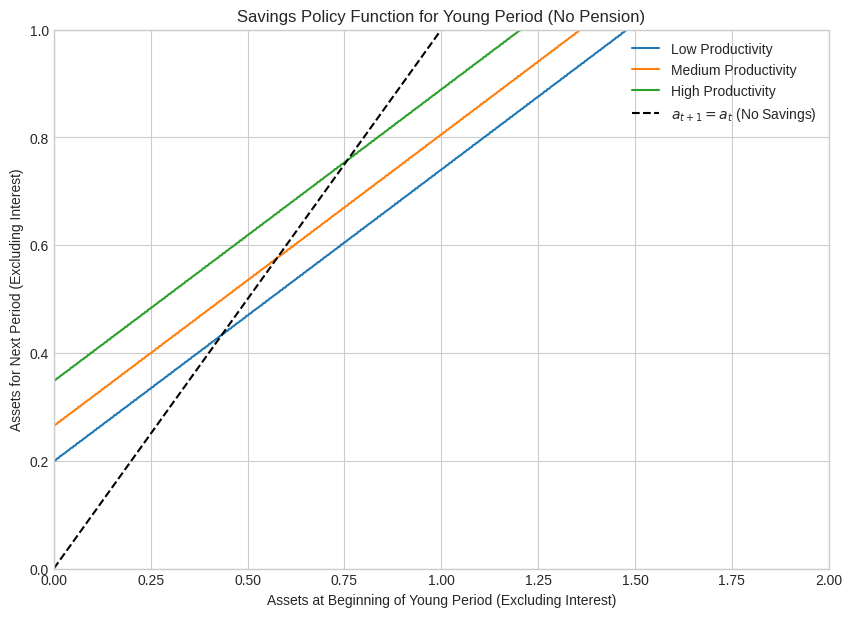

Plot generated.


In [70]:
# Question 1
# =============================================================================
if __name__ == '__main__':
    # Solve and Plot for Question 1: No Pension Scenario
    print("Solving the model for Question 1 (no pension)...")

    # The "no pension" case has no pension benefit (pension_b=0) and no taxes (tax_tau=0).
    policy_a2_no_pension, _, _= solve_model_with_optimizer(pension_b=0.0, tax_tau=0.0)

    print("Solving complete. Generating plot...")

    # [cite_start]Plotting the results as specified in Question 1. [cite: 8]
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 7))

    productivity_labels = ['Low Productivity', 'Medium Productivity', 'High Productivity']

    # [cite_start]Plot a line for each of the three productivity types. [cite: 8]
    for i in range(N_Y):
        ax.plot(A_GRID, policy_a2_no_pension[:, i], label=productivity_labels[i])

    # Add a 45-degree line for reference (where savings = initial assets).
    ax.plot(A_GRID, A_GRID, 'k--', label='$a_{t+1} = a_{t}$ (No Savings)')

    # [cite_start]Formatting the plot according to the question's instructions. [cite: 8]
    ax.set_xlabel('Assets at Beginning of Young Period (Excluding Interest)')
    ax.set_ylabel('Assets for Next Period (Excluding Interest)')
    ax.set_title('Savings Policy Function for Young Period (No Pension)')
    ax.legend()
    ax.set_xlim(0, A_MAX)
    ax.set_ylim(0, A_MAX / 2) # Adjust y-limit for better visualization

    plt.show()
    print("Plot generated.")

In [71]:
#  問題2
# =============================================================================

# 中年期の各生産性タイプの人口比率を計算：若年期の人口比率と遷移行列の積
# middle_age_prod_dist[j] = sum_i (若年期iタイプの比率 * iからjへの遷移確率)
middle_age_prod_dist = np.dot(POP_SHARES, P)

# 政府の総税収を計算
# 中年期の各タイプの人口比率に、そのタイプの税額（所得 * 税率）を掛けて合計。
total_tax_revenue = np.sum(middle_age_prod_dist * (TAU * Y_LEVELS))

#  一人当たりの年金額を計算
# 総税収を利子率Rで運用し、年金の原資とします。
pension_fund = total_tax_revenue * (1 + R)
# 全人口が1、老年期の人口も1。一人当たりの年金額は年金原資そのもの
pension_b = pension_fund

# =============================================================================
# 計算結果の出力
# =============================================================================
print("--- 問題2の計算結果 ---")
print(f"政府の総税収 (Total Government Tax Revenue): {total_tax_revenue:.4f}")
print(f"一人当たりの年金額 (Per-Capita Pension Amount): {pension_b:.4f}")

--- 問題2の計算結果 ---
政府の総税収 (Total Government Tax Revenue): 0.3043
一人当たりの年金額 (Per-Capita Pension Amount): 0.4986


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12408 (\N{HIRAGANA LETTER HE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36039 (\N{CJK UNIFIED IDEOGRAPH-8CC7}) missing from font(s) Liberation Sans.
  fig.ca

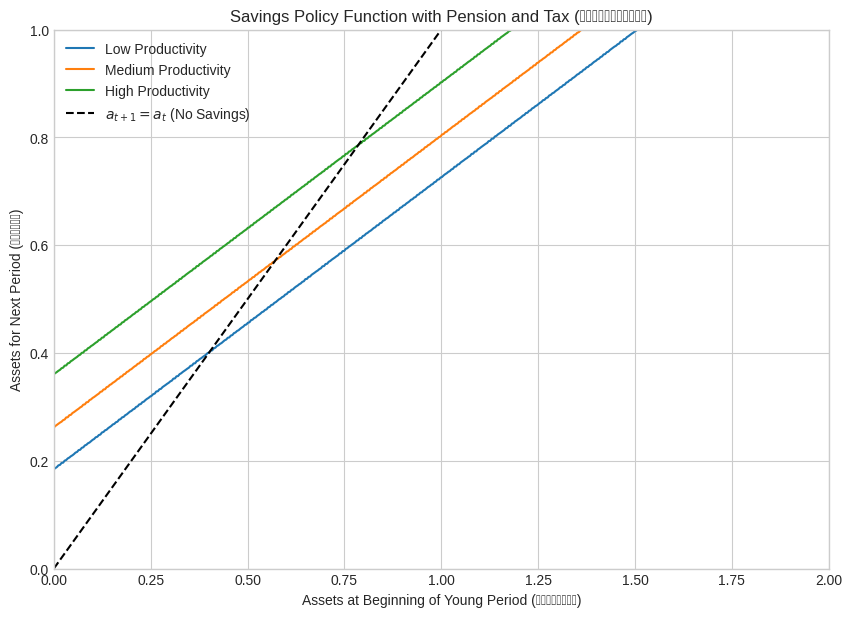

In [72]:
# 問題3
# =============================================================================
if __name__ == '__main__':
    # 年金がある場合
    policy_a2_with_pension, _, _ = solve_model_with_optimizer(pension_b=pension_b, tax_tau=TAU)

    # グラフを作成
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 7))

    productivity_labels = ['Low Productivity', 'Medium Productivity', 'High Productivity']

    # 生産性タイプごとに貯蓄政策関数をプロット
    for i in range(N_Y):
        ax.plot(A_GRID, policy_a2_with_pension[:, i], label=productivity_labels[i])

    # 比較のための45度線を追加
    ax.plot(A_GRID, A_GRID, 'k--', label='$a_{t+1} = a_{t}$ (No Savings)')

    # グラフのフォーマット設定
    ax.set_xlabel('Assets at Beginning of Young Period (若年期期初の資産)')
    ax.set_ylabel('Assets for Next Period (次期への資産)')
    ax.set_title('Savings Policy Function with Pension and Tax (年金・所得税ありの場合)')
    ax.legend()
    ax.set_xlim(0, A_MAX)
    ax.set_ylim(0, A_MAX / 2)

    plt.show()

In [73]:
# 問題4
# =============================================================================
if __name__ == '__main__':
    # 両方のシナリオでモデルを解き、価値関数を取得 ---
    print("年金がない場合の生涯効用を計算中...")
    _, _, v1_no_pension = solve_model_with_optimizer(pension_b=0.0, tax_tau=0.0)

    print("年金がある場合の生涯効用を計算中...")
    _, _, v1_with_pension = solve_model_with_optimizer(pension_b=pension_b, tax_tau=TAU)

    # 問題4の厚生分析を実行 ---
    print("--- 問題4：厚生分析の結果 ---")

    # 問題の指示通り、若年期の初期資産がゼロ(a1=0)の場合を分析
    # 資産グリッドの最初のインデックス(0)がa1=0に対応
    a1_zero_idx = 0

    # 初期資産ゼロの場合の、各生産性タイプの生涯効用を抽出
    v1_at_zero_no_pension = v1_no_pension[a1_zero_idx, :]
    v1_at_zero_with_pension = v1_with_pension[a1_zero_idx, :]

    # 人口比率で加重平均し、経済全体の平均期待生涯効用を計算
    W_no_pension = np.dot(POP_SHARES, v1_at_zero_no_pension)
    W_with_pension = np.dot(POP_SHARES, v1_at_zero_with_pension)

    # 計算結果を出力
    print(f"経済全体の平均期待生涯効用（年金なし）: {W_no_pension:.4f}")
    print(f"経済全体の平均期待生涯効用（年金あり）: {W_with_pension:.4f}")

    utility_change = W_with_pension - W_no_pension
    print(f"平均生涯効用の変化: {utility_change:+.4f}")

    # 効用が増加したか減少したかを結論として表示
    if utility_change > 0:
        print("\n結論: 年金制度の導入によって、経済全体の平均期待生涯効用は【増加】します。")
    elif utility_change < 0:
        print("\n結論: 年金制度の導入によって、経済全体の平均期待生涯効用は【減少】します。")
    else:
        print("\n結論: 年金制度の導入は、経済全体の平均期待生涯効用に影響を与えません。")


年金がない場合の生涯効用を計算中...
年金がある場合の生涯効用を計算中...
--- 問題4：厚生分析の結果 ---
経済全体の平均期待生涯効用（年金なし）: -3.0028
経済全体の平均期待生涯効用（年金あり）: -2.9843
平均生涯効用の変化: +0.0185

結論: 年金制度の導入によって、経済全体の平均期待生涯効用は【増加】します。
